## Introduction
In Part 9 KMeans Clustering vs LDA Topic Modeling. we did topic modeling on the 1941 papers mentioned Polymerase.

Topic Modeling helped us quickly gain the big picture of the major topics in a large collection of papers. It also helps by giving a rough index so you know where to look for the type of information you want (which cluster you should go). For example, if you are looking for information about diagnosis assay, you should probably go to "Group 5 diagnosis assay detection" to find information faster. If you are interested about "children" and "clinical" related information, you should go to "Group 1 flu children clinical".


The topics identified as below:
### Topics:
#### G0 flu children clinical
#### G1 gene protein cell 
#### G2 bat host phylogenetic 
#### G3 SARS COV MERS COV
#### G4 diganosis asssay detection 
#### G5 RdRp RNA replication


## Method
#### Use these topics as labels, we can use the 1941 papers (subset on March 26) as a training dataset to build a classification model that classify new papers. I use 388 papers newly updated papers (subet of April 12-subset on March 26) as a test dataset to give these new papers a topic label.

### Steps:
#### Use Universal Sentence Encoder (USE) to vectorize abstracts to 512 dimension vectors.
#### Use the G0-5 as the true labels to train classifers.
#### Validate each classifier achieved good performance.
#### Majority vote of RF, GXB, MLP to generate the final prediction.

## Results
XGB predictions match well with MLP predictions with 89.4% agreement.

XGB vs RF: agree on 81.2% of the predictions

MLP vs RF: agree on 81.4% of the predictions

There are 10 instances that all three methods produce different predictions. So the majority vote would not work. For a problem like this with 6 classes, we need at least 7 different models to ensemble to make sure there is a majority vote result.


## Future work
#### To improve the models, consider it is a imbalance dataset use class weight.


## Code
#### The code for prepare the data and other classifiers are on GitHub:
#### https://github.com/lj89/CORD19/tree/master/Part%2010%20Classify%20a%20new%20paper%20with%20RF%2C%20XGB%20and%20MLP


In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from time import time

In [3]:
from tensorflow.keras.layers import  SimpleRNN 

In [4]:
from tensorflow.keras import regularizers

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [6]:
import tensorflow as tf;print("tensorflow:",tf.__version__)
from tensorflow.keras import layers

tensorflow: 2.0.0-alpha0


In [7]:
directory = 'C:/Users/N1110/Desktop/SMU 2020 SPRING/CORD19/april 15 afternoon/'
df1= pd.read_csv('Train1941_512vectorsWithTitles.csv')
df1.head()

,title,abstract,Group,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,Selective induction of interleukin-6 in mouse ...,Abstract Astrocytes produce granulocyte/macrop...,1,0.024093,0.003332,0.026175,-0.056424,0.066987,0.064344,-0.015630,...,-0.030333,-0.068542,0.004144,-0.068533,-0.047693,-0.045203,0.038434,-0.052579,-0.026946,-0.064774
1,The coronavirus avian infectious bronchitis vi...,Abstract Replication of avian infectious bronc...,5,0.000738,0.028788,0.008383,0.015660,-0.002792,-0.023342,0.039279,...,-0.064577,-0.065933,-0.046359,-0.065978,-0.057970,-0.046468,0.047742,-0.053377,-0.034778,0.007275
2,Effect of sulfhydryl reagents on the infectivi...,Abstract The infectivity of vesicular stomatit...,1,-0.029008,0.036773,0.016296,-0.066768,0.026380,0.067563,0.040172,...,-0.009418,-0.068801,-0.007311,-0.068773,-0.016543,0.005688,0.041948,-0.049344,-0.005887,-0.032376
3,Further characterization of mouse hepatitis vi...,Abstract Two temporally and enzymatically dist...,5,0.025092,-0.005877,0.036179,-0.007282,0.044100,0.047946,0.032226,...,-0.057155,-0.065491,-0.047325,-0.065456,-0.027758,-0.018844,0.033387,-0.059728,-0.057004,-0.043818
4,Characterization of Kunjin virus RNA-dependent...,Abstract RNA-dependent RNA polymerase (RDRP) a...,5,-0.020635,0.030479,-0.051886,-0.055125,-0.052440,0.051107,-0.022648,...,-0.028083,-0.061142,-0.018120,-0.061137,-0.049363,-0.026236,0.053327,-0.014145,-0.046835,-0.060753


In [8]:
df1.shape

(1941, 515)

In [9]:
df1.dtypes

title        object
abstract     object
Group         int64
0           float64
1           float64
             ...   
507         float64
508         float64
509         float64
510         float64
511         float64
Length: 515, dtype: object

In [10]:
df1.describe()

,Group,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,2.112313,-0.033354,0.025039,-0.029933,-0.025233,0.016948,0.033986,0.030405,-0.025332,0.009630,...,-0.041908,-0.062183,-0.022047,-0.062076,0.022722,-0.019891,0.033020,-0.043147,-0.017537,-0.047506
std,1.926152,0.030242,0.034592,0.027972,0.030341,0.036274,0.032438,0.032549,0.031832,0.040776,...,0.025084,0.003800,0.033338,0.003946,0.034609,0.034151,0.022946,0.021903,0.035407,0.020467
min,0.000000,-0.073090,-0.064182,-0.067201,-0.076231,-0.067943,-0.063158,-0.073909,-0.066887,-0.074878,...,-0.070765,-0.081105,-0.066845,-0.083125,-0.065105,-0.075116,-0.061486,-0.068634,-0.069124,-0.073304
25%,1.000000,-0.056988,0.002409,-0.052341,-0.049912,-0.009887,0.020013,0.013695,-0.051979,-0.028134,...,-0.058623,-0.064305,-0.049817,-0.064194,-0.000385,-0.049479,0.021046,-0.057128,-0.047880,-0.059254
50%,1.000000,-0.046209,0.036926,-0.039104,-0.035005,0.027843,0.048174,0.043775,-0.035518,0.017565,...,-0.053042,-0.061603,-0.031897,-0.061564,0.034213,-0.029447,0.038922,-0.051624,-0.027722,-0.056003
75%,4.000000,-0.015791,0.054346,-0.014463,-0.005188,0.047873,0.057508,0.055454,-0.004598,0.047810,...,-0.033597,-0.059599,0.000451,-0.059553,0.051864,0.004885,0.050912,-0.037323,0.009025,-0.044880
max,5.000000,0.062857,0.072260,0.064023,0.058647,0.067745,0.072100,0.069029,0.062444,0.072816,...,0.054437,-0.053319,0.068436,-0.030560,0.071195,0.065397,0.064143,0.060514,0.063298,0.055845


In [11]:
# check missing values
df1.isnull().sum()


title       0
abstract    0
Group       0
0           0
1           0
           ..
507         0
508         0
509         0
510         0
511         0
Length: 515, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BD5EF9FA58>]],
      dtype=object)

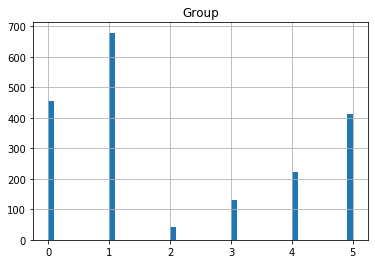

In [12]:
df1.hist(column='Group', bins=50)

In [13]:
df_imputed=df1.drop(['title', 'abstract'], axis=1)
df_imputed


,Group,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1,0.024093,0.003332,0.026175,-0.056424,0.066987,0.064344,-0.015630,-0.065082,0.063505,...,-0.030333,-0.068542,0.004144,-0.068533,-0.047693,-0.045203,0.038434,-0.052579,-0.026946,-0.064774
1,5,0.000738,0.028788,0.008383,0.015660,-0.002792,-0.023342,0.039279,-0.006778,-0.046869,...,-0.064577,-0.065933,-0.046359,-0.065978,-0.057970,-0.046468,0.047742,-0.053377,-0.034778,0.007275
2,1,-0.029008,0.036773,0.016296,-0.066768,0.026380,0.067563,0.040172,-0.060464,-0.026711,...,-0.009418,-0.068801,-0.007311,-0.068773,-0.016543,0.005688,0.041948,-0.049344,-0.005887,-0.032376
3,5,0.025092,-0.005877,0.036179,-0.007282,0.044100,0.047946,0.032226,0.004009,0.051182,...,-0.057155,-0.065491,-0.047325,-0.065456,-0.027758,-0.018844,0.033387,-0.059728,-0.057004,-0.043818
4,5,-0.020635,0.030479,-0.051886,-0.055125,-0.052440,0.051107,-0.022648,-0.009215,0.052870,...,-0.028083,-0.061142,-0.018120,-0.061137,-0.049363,-0.026236,0.053327,-0.014145,-0.046835,-0.060753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,4,-0.044237,-0.020313,-0.048073,-0.056209,0.043061,0.056523,-0.000632,0.027694,0.040570,...,-0.058062,-0.058796,-0.045975,-0.058796,0.050993,-0.033669,0.041798,-0.057656,-0.012462,-0.054203
1937,5,-0.035588,0.058073,-0.050484,-0.037032,0.016111,0.060505,0.057046,-0.047282,0.031583,...,-0.059808,-0.061199,-0.018811,-0.061199,-0.020907,-0.026319,0.028944,-0.047205,-0.041322,-0.023640
1938,0,-0.060424,-0.000134,-0.058672,-0.038685,0.032710,0.027704,-0.024062,-0.059046,0.029137,...,-0.061882,-0.062241,-0.037259,-0.062241,0.039949,0.027875,0.060479,-0.058036,-0.061445,-0.058604
1939,0,-0.013489,0.049279,-0.059444,-0.058115,-0.059752,-0.035380,0.058563,-0.054313,0.057236,...,-0.059849,-0.062269,-0.055467,-0.062269,0.023908,-0.041097,0.012535,-0.033178,-0.048842,-0.040750


In [14]:
# we want to predict the X and y data as follows:

if 'Group' in df_imputed:
    y = df_imputed['Group'].values # get the labels we want
    del df_imputed['Group'] # get rid of the class label
    X = df_imputed.values # use everything else to predict

In [15]:
type(y)

numpy.ndarray

In [16]:
type(X)

numpy.ndarray

In [17]:
# features=

In [18]:
# #it's good practice to Scale Data
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train = scaler.fit_transform(X)
# scaled_train_df = pd.DataFrame(scaled_train, columns=features)

In [19]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1776)

In [20]:
type(X_test)

numpy.ndarray

In [21]:

print(len(y_test))
print(len(y_train))

389
1552


In [22]:
from tensorflow.keras.callbacks import TensorBoard
tb = TensorBoard(log_dir=f"logs\\{time()}")


In [23]:
tf.compat.v1.disable_eager_execution() #disable eager execution,since got error AttributeError: Tensor.graph is meaningless when eager execution is enabled.

In [26]:
FEATURES=512
weight_decay=1e-5

In [27]:
model = tf.keras.Sequential([
    layers.Dense(300, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                 #kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.1),
        layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    #layers.Dense(units, activation=activation_func),
    #layers.SimpleRNN(100,unroll=True),
    layers.Dense(6 ,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=10)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=74, batch_size=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               153900    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               9

1552/1552 [==============================] - 0s 186us/sample - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.7590 - val_accuracy: 0.8252
Epoch 46/74
1552/1552 [==============================] - 0s 137us/sample - loss: 0.0095 - accuracy: 0.9987 - val_loss: 0.8775 - val_accuracy: 0.8406
Epoch 47/74
1552/1552 [==============================] - 0s 188us/sample - loss: 0.0099 - accuracy: 0.9987 - val_loss: 0.8753 - val_accuracy: 0.8303
Epoch 48/74
1552/1552 [==============================] - 0s 161us/sample - loss: 0.0098 - accuracy: 0.9987 - val_loss: 0.9138 - val_accuracy: 0.8406
Epoch 49/74
1552/1552 [==============================] - 0s 165us/sample - loss: 0.0130 - accuracy: 0.9974 - val_loss: 0.8345 - val_accuracy: 0.8406
Epoch 50/74
1552/1552 [==============================] - 0s 145us/sample - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.8707 - val_accuracy: 0.8226
Epoch 51/74
1552/1552 [==============================] - 0s 138us/sample - loss: 0.0065 - accuracy: 1.0000 - val_loss:

In [28]:
model2 = tf.keras.Sequential([
    layers.Dense(300, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                 #kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.1),
        layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    #layers.Dense(units, activation=activation_func),
    #layers.SimpleRNN(100,unroll=True),
    layers.Dense(6 ,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=10)

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               153900    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               9

1552/1552 [==============================] - 0s 119us/sample - loss: 0.0700 - accuracy: 0.9865 - val_loss: 0.5517 - val_accuracy: 0.8406
Epoch 46/150
1552/1552 [==============================] - 0s 118us/sample - loss: 0.0739 - accuracy: 0.9832 - val_loss: 0.5525 - val_accuracy: 0.8432
Epoch 47/150
1552/1552 [==============================] - 0s 99us/sample - loss: 0.0616 - accuracy: 0.9858 - val_loss: 0.5419 - val_accuracy: 0.8406
Epoch 48/150
1552/1552 [==============================] - 0s 117us/sample - loss: 0.0583 - accuracy: 0.9858 - val_loss: 0.5726 - val_accuracy: 0.8509
Epoch 49/150
1552/1552 [==============================] - 0s 105us/sample - loss: 0.0490 - accuracy: 0.9903 - val_loss: 0.5906 - val_accuracy: 0.8535
Epoch 50/150
1552/1552 [==============================] - 0s 118us/sample - loss: 0.0466 - accuracy: 0.9916 - val_loss: 0.5795 - val_accuracy: 0.8432
Epoch 51/150
1552/1552 [==============================] - 0s 110us/sample - loss: 0.0420 - accuracy: 0.9936 - val_

Epoch 100/150
1552/1552 [==============================] - 0s 131us/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.9260 - val_accuracy: 0.8278
Epoch 101/150
1552/1552 [==============================] - 0s 111us/sample - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.9181 - val_accuracy: 0.8406
Epoch 102/150
1552/1552 [==============================] - 0s 127us/sample - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.9032 - val_accuracy: 0.8303
Epoch 103/150
1552/1552 [==============================] - 0s 119us/sample - loss: 0.0070 - accuracy: 0.9994 - val_loss: 0.9184 - val_accuracy: 0.8355
Epoch 104/150
1552/1552 [==============================] - 0s 106us/sample - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.9177 - val_accuracy: 0.8329
Epoch 105/150
1552/1552 [==============================] - 0s 179us/sample - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.9167 - val_accuracy: 0.8329
Epoch 106/150
1552/1552 [==============================] - 0s 152us/sample - loss: 0.0057 - ac

In [29]:
X_test.shape

(389, 512)

In [31]:
 
y_pred_keras = model2.predict(X_test)[:, :]
y_pred_keras

array([[9.5731299e-03, 5.2631032e-01, 3.7737048e-04, 4.6344689e-01,
        2.6438874e-04, 2.7860471e-05],
       [6.3374396e-11, 3.8282865e-01, 1.5953320e-06, 3.9615802e-08,
        2.1569338e-07, 6.1716950e-01],
       [2.9101342e-15, 3.8773679e-10, 3.9593419e-11, 1.0189453e-08,
        3.3719264e-12, 1.0000000e+00],
       ...,
       [2.6858095e-14, 1.0029092e-07, 6.0756061e-10, 4.4949973e-09,
        2.7131176e-11, 9.9999988e-01],
       [5.1457187e-14, 1.8195551e-09, 4.3263088e-10, 5.9100960e-09,
        1.1759822e-11, 1.0000000e+00],
       [7.5174970e-15, 9.7326648e-01, 1.7150293e-09, 3.3121278e-10,
        1.9109669e-09, 2.6733540e-02]], dtype=float32)

In [41]:
max_index = np.argmax(y_pred_keras, axis=1)
max_index

array([1, 5, 5, 0, 5, 5, 0, 1, 1, 1, 0, 4, 4, 1, 4, 5, 5, 1, 1, 5, 4, 0,
       1, 0, 0, 5, 4, 0, 1, 5, 0, 5, 0, 5, 4, 5, 5, 3, 4, 4, 3, 1, 1, 0,
       5, 1, 4, 1, 1, 0, 1, 0, 5, 0, 1, 0, 0, 0, 1, 5, 1, 5, 1, 1, 4, 0,
       0, 5, 1, 3, 4, 1, 4, 1, 0, 1, 4, 1, 1, 0, 1, 0, 1, 0, 1, 1, 5, 4,
       2, 0, 0, 0, 1, 5, 0, 1, 0, 1, 3, 0, 1, 1, 0, 3, 1, 0, 0, 1, 1, 4,
       1, 1, 3, 1, 0, 5, 4, 4, 0, 5, 0, 5, 0, 5, 1, 1, 5, 5, 1, 0, 4, 1,
       4, 1, 1, 0, 4, 0, 0, 5, 1, 1, 1, 3, 1, 1, 5, 0, 5, 1, 5, 1, 1, 0,
       1, 5, 1, 0, 5, 1, 0, 4, 0, 4, 1, 5, 0, 0, 3, 4, 3, 5, 1, 5, 2, 4,
       1, 1, 1, 1, 1, 0, 5, 1, 1, 1, 0, 1, 1, 0, 3, 1, 5, 1, 0, 5, 3, 1,
       0, 4, 1, 1, 3, 1, 0, 5, 0, 5, 5, 5, 1, 4, 4, 1, 1, 5, 1, 4, 1, 4,
       1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 0, 0, 5, 1, 2, 1, 5, 4, 0, 1, 0, 4,
       1, 4, 3, 1, 4, 1, 1, 1, 5, 1, 0, 1, 1, 5, 1, 5, 1, 2, 5, 5, 4, 1,
       0, 1, 5, 1, 0, 1, 4, 1, 3, 2, 0, 1, 1, 2, 3, 0, 3, 5, 0, 1, 1, 1,
       5, 0, 1, 0, 1, 1, 3, 3, 0, 5, 3, 5, 0, 0, 5,

In [42]:
y_test

array([3, 5, 5, 0, 5, 5, 3, 1, 1, 1, 0, 4, 4, 1, 4, 1, 5, 1, 1, 5, 4, 0,
       1, 0, 0, 5, 4, 0, 1, 1, 0, 5, 0, 5, 4, 5, 5, 1, 4, 4, 3, 1, 1, 0,
       5, 1, 4, 1, 1, 0, 1, 0, 1, 0, 1, 3, 1, 0, 1, 5, 3, 5, 5, 1, 4, 0,
       1, 5, 1, 0, 4, 1, 4, 1, 0, 1, 4, 1, 1, 0, 5, 0, 1, 0, 1, 5, 5, 1,
       2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 4,
       3, 1, 1, 1, 0, 5, 4, 4, 0, 5, 0, 5, 0, 5, 1, 5, 5, 5, 1, 0, 1, 1,
       4, 1, 1, 0, 4, 0, 1, 5, 1, 1, 1, 3, 1, 1, 5, 0, 5, 4, 1, 1, 1, 0,
       1, 5, 1, 0, 5, 4, 0, 4, 4, 4, 1, 5, 0, 0, 3, 1, 3, 5, 1, 5, 2, 4,
       1, 1, 1, 0, 1, 0, 5, 5, 1, 1, 0, 1, 1, 0, 4, 1, 3, 3, 1, 5, 3, 3,
       0, 4, 1, 1, 0, 1, 0, 5, 0, 5, 5, 5, 5, 4, 1, 3, 1, 5, 1, 4, 1, 4,
       1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 0, 0, 5, 1, 2, 0, 5, 4, 0, 1, 0, 4,
       1, 4, 3, 1, 1, 1, 5, 1, 5, 1, 0, 1, 1, 5, 5, 5, 1, 2, 5, 5, 4, 2,
       0, 3, 5, 5, 0, 5, 4, 1, 3, 2, 0, 1, 1, 2, 3, 0, 5, 5, 0, 1, 1, 1,
       5, 1, 1, 0, 1, 5, 3, 3, 0, 5, 4, 5, 0, 0, 5,

In [43]:
max_index-y_test

array([-2,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,
        0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  4,  0,  0, -3, -1,  0,  0,  0, -2,  0, -4,  0,  0,  0, -1,  0,
        0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -4,  0,  0,  0,  0,
       -4,  0,  3,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  2,  0,  0,  0,
        0,  3,  0,  0,  0,  0,  0,  0, -2,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -4,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  4,  0,  0,
        0,  0,  0,  0,  0,  0, -3,  0,  0, -4,  0,  0,  0,  0,  0,  0,  3,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -4,  0,  0,  0,
        0,  0,  0, -1,  0,  2, -2, -1,  0,  0, -2,  0,  0,  0,  0,  3,  0,
        0,  0,  0,  0,  0,  0, -4,  0,  3, -2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [45]:
sum((max_index-y_test)==0)/X_test.shape[0] #verify the method to calculate accuracy, confirm the number matches val loss output

0.8303341902313625

## Predict Hold Out dataset (new papers, no label)

In [46]:
df2= pd.read_csv('HoldOut388_512vectors2WithTitles.csv')
df2.head()

,title,abstract,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,Synthesis of virus-specific RNA in permeabiliz...,Abstract We have developed a permeabilized cel...,-0.049652,-0.011094,-0.026801,-0.002311,0.042196,0.021205,-0.003560,0.020746,...,-0.056881,-0.070640,-0.017600,-0.070502,-0.000305,-0.008354,0.054538,-0.007377,-0.035350,-0.052909
1,Primary structure and post-translational proce...,Abstract The nucleotide sequence of the peplom...,0.002379,0.018184,-0.040164,-0.030494,0.008339,0.061669,-0.012344,-0.002478,...,-0.051405,-0.065164,-0.010036,-0.065149,0.049234,-0.030314,0.048964,0.011794,-0.028852,-0.064704
2,Comparison of the genome organization of toro-...,"Abstract Recently, toroviruses and coronavirus...",-0.036349,-0.000761,-0.050869,-0.034782,0.035800,0.060601,0.005766,-0.029210,...,0.035874,-0.063528,-0.059635,-0.063528,0.034254,-0.030137,0.043699,-0.005431,0.057524,-0.056803
3,The complete sequence (22 kilobases) of murine...,"Abstract The 5′-most gene, gene 1, of the geno...",0.007206,-0.013924,-0.027915,0.040264,0.007304,0.058013,-0.036737,0.023549,...,-0.057039,-0.058295,-0.052740,-0.058295,0.014025,-0.054457,0.053144,-0.055570,0.049414,-0.057258
4,De novo generation of defective interfering RN...,Abstract Defective interfering (DI) RNAs were ...,-0.049280,-0.035973,-0.050783,-0.031401,0.031795,0.059310,0.052120,0.020553,...,-0.010444,-0.062296,-0.037243,-0.062295,-0.053315,-0.030183,0.038881,-0.047072,0.060653,-0.056800


In [47]:
df_imputed2=df2.drop(['title', 'abstract'], axis=1)
df_imputed2

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.049652,-0.011094,-0.026801,-0.002311,0.042196,0.021205,-0.003560,0.020746,0.045434,0.025883,...,-0.056881,-0.070640,-0.017600,-0.070502,-0.000305,-0.008354,0.054538,-0.007377,-0.035350,-0.052909
1,0.002379,0.018184,-0.040164,-0.030494,0.008339,0.061669,-0.012344,-0.002478,0.036577,0.026191,...,-0.051405,-0.065164,-0.010036,-0.065149,0.049234,-0.030314,0.048964,0.011794,-0.028852,-0.064704
2,-0.036349,-0.000761,-0.050869,-0.034782,0.035800,0.060601,0.005766,-0.029210,0.022040,0.053824,...,0.035874,-0.063528,-0.059635,-0.063528,0.034254,-0.030137,0.043699,-0.005431,0.057524,-0.056803
3,0.007206,-0.013924,-0.027915,0.040264,0.007304,0.058013,-0.036737,0.023549,0.011380,0.048981,...,-0.057039,-0.058295,-0.052740,-0.058295,0.014025,-0.054457,0.053144,-0.055570,0.049414,-0.057258
4,-0.049280,-0.035973,-0.050783,-0.031401,0.031795,0.059310,0.052120,0.020553,0.001214,0.057714,...,-0.010444,-0.062296,-0.037243,-0.062295,-0.053315,-0.030183,0.038881,-0.047072,0.060653,-0.056800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.000114,0.058478,-0.004469,-0.063835,0.006031,0.020011,0.008401,-0.063798,0.057093,-0.025551,...,-0.015296,-0.067067,-0.012751,-0.067071,-0.028087,-0.046303,0.056527,-0.058321,-0.019072,-0.036170
384,-0.048442,-0.035224,-0.057540,-0.035870,0.056764,0.058271,0.055362,-0.055081,0.045430,0.043651,...,-0.032115,-0.061738,-0.052958,-0.061738,0.044325,-0.048101,0.059945,-0.059864,-0.048209,-0.052417
385,-0.038116,-0.015935,-0.051716,0.026050,0.053225,0.058031,0.043148,-0.037475,0.028737,0.049610,...,-0.040447,-0.061073,-0.030382,-0.061073,0.006920,-0.007703,0.049406,-0.058802,-0.046988,-0.056345
386,-0.055184,0.056014,-0.050239,0.027768,-0.047458,-0.010766,0.043399,-0.054596,-0.028848,-0.024939,...,-0.037741,-0.056081,-0.044042,-0.056081,0.054785,-0.054763,0.039602,0.006800,0.003140,-0.056081


In [48]:
x_test2=df_imputed2
x_test2.shape

(388, 512)

In [49]:
y_pred_keras2 = model2.predict(x_test2)[:, :]
y_pred_keras2

array([[3.6764970e-13, 1.9692442e-04, 5.6723306e-09, 9.6481312e-09,
        4.5470461e-08, 9.9980301e-01],
       [6.0039992e-14, 1.7254754e-06, 1.3729931e-09, 6.3185183e-08,
        9.7330775e-11, 9.9999821e-01],
       [3.2728131e-15, 4.1799685e-11, 2.1057968e-11, 5.0903433e-09,
        2.1310488e-12, 1.0000000e+00],
       ...,
       [1.5166425e-10, 8.4924528e-07, 1.1948390e-07, 2.5660620e-06,
        1.7249308e-08, 9.9999642e-01],
       [3.2596505e-01, 1.5062708e-01, 4.2049721e-04, 5.2298576e-01,
        9.2161463e-07, 6.6337554e-07],
       [9.9999452e-01, 1.4166167e-06, 2.2941456e-06, 1.6106654e-06,
        1.3691961e-07, 2.5797693e-09]], dtype=float32)

In [53]:
max_indexMLP = np.argmax(y_pred_keras2, axis=1)
max_indexMLP

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 5, 1,
       1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4, 3, 1, 5, 5,
       4, 4, 1, 1, 1, 4, 1, 1, 0, 4, 0, 1, 5, 0, 4, 1, 5, 1, 5, 3, 5, 5,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 4, 5, 1, 1, 5, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 5, 1, 1, 1, 1, 5, 0, 0, 5, 4, 1, 0, 1, 1,
       4, 1, 0, 4, 4, 1, 4, 4, 3, 0, 1, 3, 3, 4, 1, 0, 5, 1, 3, 0, 3, 1,
       0, 5, 1, 5, 3, 1, 1, 1, 1, 5, 4, 0, 1, 1, 4, 4, 4, 0, 4, 1, 0, 0,
       1, 0, 0, 3, 5, 2, 0, 1, 1, 0, 4, 1, 1, 0, 0, 5, 1, 1, 0, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 4, 5, 0, 5, 1, 0, 1,
       5, 0, 1, 1, 5, 1, 1, 5, 2, 5, 5, 0, 5, 1, 3, 0, 1, 4, 0, 1, 1, 5,
       5, 0, 1, 1, 5, 0, 5, 1, 2, 3, 1, 0, 1, 5, 1, 4, 5, 1, 5, 1, 2, 5,
       1, 5, 0, 0, 1, 2, 5, 0, 0, 5, 1, 5, 2, 5, 5, 1, 5, 5, 5, 3, 0, 1,
       4, 1, 5, 5, 1, 5, 5, 1, 5, 1, 1, 1, 5, 4, 0, 5, 1, 5, 1, 2, 2, 0,
       1, 1, 5, 5, 1, 5, 5, 3, 2, 4, 1, 1, 5, 5, 0,

## Validation method 2
## Compare MLP with RF predictions

In [ ]:
## compare MLP with RF predictions

# RF results:
# preds[0:20] 
# Out[48]:
# array([[0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 1, 0, 0, 0, 0],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 1, 0],
#        [0, 0, 0, 0, 1, 0],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1]], dtype=uint8)
# [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5],

# MLP results 1-20
# [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 

## For the two methods, the first 20 predictions match perfectly!

In [ ]:
# RF preds[21:40]

# Out[51]:
# array([[0, 1, 0, 0, 0, 0],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 1, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 1, 0, 0, 0, 0],
#        [0, 1, 0, 0, 0, 0],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 1, 0],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 1, 0, 0, 0, 0],
#        [0, 0, 0, 0, 0, 1],
#        [0, 0, 0, 0, 1, 0]], dtype=uint8)
#([1, 1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4],

# MLP results 21-40
# 5, 1, 1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4,

In [66]:
max_indexRF=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 5, 1,
       1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4, 3, 1, 5, 5,
       1, 4, 1, 0, 1, 4, 1, 1, 0, 4, 0, 1, 5, 0, 4, 1, 5, 1, 5, 3, 5, 5,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4, 1, 4, 5, 1, 1, 5, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 5, 1, 1, 1, 1, 5, 0, 0, 5, 4, 1, 0, 1, 1,
       4, 1, 0, 4, 4, 1, 4, 4, 3, 0, 1, 0, 0, 4, 1, 0, 5, 1, 3, 1, 3, 1,
       0, 5, 1, 5, 3, 5, 1, 1, 1, 5, 4, 0, 1, 1, 4, 4, 4, 0, 4, 1, 0, 0,
       1, 0, 0, 3, 5, 2, 0, 1, 1, 0, 4, 1, 3, 0, 0, 5, 1, 1, 0, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 4, 5, 0, 5, 1, 0, 1,
       5, 0, 5, 1, 5, 1, 1, 5, 1, 5, 1, 0, 5, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       5, 1, 1, 1, 5, 0, 5, 1, 1, 0, 1, 0, 1, 5, 1, 4, 5, 1, 0, 1, 1, 5,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 5, 0, 5, 0, 1, 5, 5, 5, 0, 0, 1,
       4, 1, 5, 5, 0, 0, 5, 1, 5, 5, 1, 0, 5, 4, 0, 5, 1, 5, 1, 1, 1, 0,
       1, 1, 5, 5, 1, 5, 5, 1, 1, 0, 1, 0, 0, 5, 0, 5, 1, 1, 1, 5, 0, 0,
       5, 0, 0, 0, 5, 1, 5, 0, 5, 5, 1, 0, 5, 5, 5, 1, 5, 1, 1, 0, 0, 5,
       1, 5, 5, 1, 5, 0, 1, 1, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 0, 0, 5, 1,
       1, 0, 0, 1, 5, 0, 0, 1, 1, 5, 1, 5, 5, 1, 5, 5, 0, 0, 0, 5, 1, 1,
       0, 0, 0, 4, 5, 0, 5, 1, 0, 1, 0, 5, 0, 0]
max_indexRF

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 5,
 1,
 1,
 4,
 4,
 1,
 5,
 5,
 5,
 1,
 1,
 5,
 1,
 5,
 5,
 4,
 5,
 1,
 1,
 1,
 5,
 1,
 4,
 1,
 5,
 1,
 5,
 4,
 3,
 1,
 5,
 5,
 1,
 4,
 1,
 0,
 1,
 4,
 1,
 1,
 0,
 4,
 0,
 1,
 5,
 0,
 4,
 1,
 5,
 1,
 5,
 3,
 5,
 5,
 1,
 5,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 1,
 4,
 4,
 1,
 4,
 5,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 5,
 1,
 1,
 1,
 1,
 5,
 0,
 0,
 5,
 4,
 1,
 0,
 1,
 1,
 4,
 1,
 0,
 4,
 4,
 1,
 4,
 4,
 3,
 0,
 1,
 0,
 0,
 4,
 1,
 0,
 5,
 1,
 3,
 1,
 3,
 1,
 0,
 5,
 1,
 5,
 3,
 5,
 1,
 1,
 1,
 5,
 4,
 0,
 1,
 1,
 4,
 4,
 4,
 0,
 4,
 1,
 0,
 0,
 1,
 0,
 0,
 3,
 5,
 2,
 0,
 1,
 1,
 0,
 4,
 1,
 3,
 0,
 0,
 5,
 1,
 1,
 0,
 0,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 4,
 5,
 0,
 5,
 1,
 0,
 1,
 5,
 0,
 5,
 1,
 5,
 1,
 1,
 5,
 1,
 5,
 1,
 0,
 5,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 5,
 1,
 1,
 1,
 5,
 0,
 5,
 1,
 1,
 0,
 1,
 0,
 1,
 5,
 1,
 4,
 5,
 1,
 0,
 1,
 1,
 5,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,


In [56]:
max_indexMLP-max_indexRF

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  3,  3,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -4,  0,  0,  0,
        0,  0,  1,  0,  4,  0,  0,  1,  3,  0,  0,  4,  0,  0,  0,  5,  0,
       -1,  0,  0,  0,  0

## How well MLP and RF predictions match?
### 0.8144329896907216
### 81.4%

### If we have a third algo results, we can have a ensemble model with majority vote.

In [57]:
sum((max_indexMLP-max_indexRF)==0)/x_test2.shape[0]

0.8144329896907216

### Therefore, I run a GXB. The result is as below:


In [63]:
max_indexXGB=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 5, 1,
       1, 5, 5, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4, 3, 4, 5, 5,
       1, 4, 1, 2, 1, 4, 1, 1, 0, 4, 0, 1, 5, 0, 4, 1, 5, 1, 5, 1, 5, 5,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4, 1, 4, 5, 1, 1, 5, 5,
       5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 5, 0, 0, 5, 4, 1, 0, 1, 1,
       4, 1, 0, 4, 4, 1, 4, 4, 1, 0, 1, 4, 3, 4, 1, 0, 1, 1, 5, 1, 3, 1,
       1, 5, 1, 5, 3, 5, 1, 1, 1, 5, 4, 0, 1, 1, 4, 4, 4, 0, 4, 1, 0, 0,
       1, 0, 0, 1, 5, 1, 0, 1, 1, 0, 4, 1, 3, 0, 0, 5, 0, 1, 0, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 4, 5, 0, 5, 1, 0, 1,
       5, 0, 5, 1, 5, 1, 1, 1, 2, 5, 5, 0, 5, 1, 3, 0, 1, 4, 0, 1, 1, 5,
       5, 1, 1, 1, 5, 0, 5, 1, 1, 3, 1, 0, 1, 5, 1, 4, 5, 1, 5, 1, 1, 5,
       1, 5, 0, 0, 1, 2, 5, 0, 0, 5, 1, 5, 2, 5, 1, 1, 5, 5, 5, 1, 0, 1,
       4, 1, 5, 5, 5, 5, 5, 1, 5, 1, 1, 1, 5, 4, 0, 5, 1, 5, 1, 2, 2, 0,
       1, 1, 5, 5, 1, 5, 5, 5, 2, 4, 1, 5, 1, 5, 0, 5, 1, 2, 1, 5, 5, 2,
       5, 5, 1, 2, 5, 4, 5, 0, 5, 5, 1, 0, 5, 5, 5, 1, 5, 5, 1, 3, 3, 5,
       5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 5, 5, 1, 5, 5, 0, 1, 1, 3, 1, 5, 5, 1, 5, 5, 2, 5, 2, 5, 1, 1,
       5, 5, 3, 4, 5, 5, 5, 1, 3, 1, 5, 5, 0, 0]

In [65]:
sum((max_indexMLP-max_indexXGB)==0)/x_test2.shape[0]

0.8943298969072165

## XGB predictions match well with MLP predictions with 89.4% agreement.
#### 0.8943298969072165

In [67]:
sum((max_indexRF-max_indexXGB)==0)/x_test2.shape[0]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [68]:
type(max_indexMLP)

numpy.ndarray

In [69]:
type(max_indexRF)

list

In [70]:
type(max_indexXGB)

list

In [72]:
npRF= np.asarray(max_indexRF, dtype=np.float32)
type(npRF)

numpy.ndarray

In [74]:
sum((npRF-max_indexXGB)==0)/x_test2.shape[0]

0.8118556701030928

## XGB vs RF: agree on 81.2% of the predictions

In [75]:
npRF-max_indexXGB

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -4.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -3.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -4., -4.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0., -4.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0., -4., -3.,  0.,  0.,  0.,  4.,  0., -2.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

## Majority Vote
### For this purpose, I will stack these three predictions and count the mode of each column.

In [79]:
dfAll = np.array([[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 5, 1,
       1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4, 3, 1, 5, 5,
       4, 4, 1, 1, 1, 4, 1, 1, 0, 4, 0, 1, 5, 0, 4, 1, 5, 1, 5, 3, 5, 5,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 4, 5, 1, 1, 5, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 5, 1, 1, 1, 1, 5, 0, 0, 5, 4, 1, 0, 1, 1,
       4, 1, 0, 4, 4, 1, 4, 4, 3, 0, 1, 3, 3, 4, 1, 0, 5, 1, 3, 0, 3, 1,
       0, 5, 1, 5, 3, 1, 1, 1, 1, 5, 4, 0, 1, 1, 4, 4, 4, 0, 4, 1, 0, 0,
       1, 0, 0, 3, 5, 2, 0, 1, 1, 0, 4, 1, 1, 0, 0, 5, 1, 1, 0, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 4, 5, 0, 5, 1, 0, 1,
       5, 0, 1, 1, 5, 1, 1, 5, 2, 5, 5, 0, 5, 1, 3, 0, 1, 4, 0, 1, 1, 5,
       5, 0, 1, 1, 5, 0, 5, 1, 2, 3, 1, 0, 1, 5, 1, 4, 5, 1, 5, 1, 2, 5,
       1, 5, 0, 0, 1, 2, 5, 0, 0, 5, 1, 5, 2, 5, 5, 1, 5, 5, 5, 3, 0, 1,
       4, 1, 5, 5, 1, 5, 5, 1, 5, 1, 1, 1, 5, 4, 0, 5, 1, 5, 1, 2, 2, 0,
       1, 1, 5, 5, 1, 5, 5, 3, 2, 4, 1, 1, 5, 5, 0, 5, 1, 2, 1, 5, 1, 2,
       5, 5, 1, 2, 5, 4, 5, 0, 5, 5, 1, 0, 5, 5, 5, 1, 5, 1, 1, 3, 3, 3,
       5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 1, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 1,
       5, 5, 5, 1, 5, 5, 0, 1, 1, 3, 1, 1, 5, 1, 5, 5, 2, 5, 2, 5, 1, 1,
       5, 5, 3, 3, 5, 5, 5, 1, 1, 1, 5, 5, 3, 0], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 5, 1,
       1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4, 3, 1, 5, 5,
       1, 4, 1, 0, 1, 4, 1, 1, 0, 4, 0, 1, 5, 0, 4, 1, 5, 1, 5, 3, 5, 5,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4, 1, 4, 5, 1, 1, 5, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 5, 1, 1, 1, 1, 5, 0, 0, 5, 4, 1, 0, 1, 1,
       4, 1, 0, 4, 4, 1, 4, 4, 3, 0, 1, 0, 0, 4, 1, 0, 5, 1, 3, 1, 3, 1,
       0, 5, 1, 5, 3, 5, 1, 1, 1, 5, 4, 0, 1, 1, 4, 4, 4, 0, 4, 1, 0, 0,
       1, 0, 0, 3, 5, 2, 0, 1, 1, 0, 4, 1, 3, 0, 0, 5, 1, 1, 0, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 4, 5, 0, 5, 1, 0, 1,
       5, 0, 5, 1, 5, 1, 1, 5, 1, 5, 1, 0, 5, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       5, 1, 1, 1, 5, 0, 5, 1, 1, 0, 1, 0, 1, 5, 1, 4, 5, 1, 0, 1, 1, 5,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 5, 0, 5, 0, 1, 5, 5, 5, 0, 0, 1,
       4, 1, 5, 5, 0, 0, 5, 1, 5, 5, 1, 0, 5, 4, 0, 5, 1, 5, 1, 1, 1, 0,
       1, 1, 5, 5, 1, 5, 5, 1, 1, 0, 1, 0, 0, 5, 0, 5, 1, 1, 1, 5, 0, 0,
       5, 0, 0, 0, 5, 1, 5, 0, 5, 5, 1, 0, 5, 5, 5, 1, 5, 1, 1, 0, 0, 5,
       1, 5, 5, 1, 5, 0, 1, 1, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 0, 0, 5, 1,
       1, 0, 0, 1, 5, 0, 0, 1, 1, 5, 1, 5, 5, 1, 5, 5, 0, 0, 0, 5, 1, 1,
       0, 0, 0, 4, 5, 0, 5, 1, 0, 1, 0, 5, 0, 0],[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 4, 4, 1, 5, 5, 5, 1,
       1, 5, 5, 5, 5, 4, 5, 1, 1, 1, 5, 1, 4, 1, 5, 1, 5, 4, 3, 4, 5, 5,
       1, 4, 1, 2, 1, 4, 1, 1, 0, 4, 0, 1, 5, 0, 4, 1, 5, 1, 5, 1, 5, 5,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4, 1, 4, 5, 1, 1, 5, 5,
       5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 5, 0, 0, 5, 4, 1, 0, 1, 1,
       4, 1, 0, 4, 4, 1, 4, 4, 1, 0, 1, 4, 3, 4, 1, 0, 1, 1, 5, 1, 3, 1,
       1, 5, 1, 5, 3, 5, 1, 1, 1, 5, 4, 0, 1, 1, 4, 4, 4, 0, 4, 1, 0, 0,
       1, 0, 0, 1, 5, 1, 0, 1, 1, 0, 4, 1, 3, 0, 0, 5, 0, 1, 0, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 4, 5, 0, 5, 1, 0, 1,
       5, 0, 5, 1, 5, 1, 1, 1, 2, 5, 5, 0, 5, 1, 3, 0, 1, 4, 0, 1, 1, 5,
       5, 1, 1, 1, 5, 0, 5, 1, 1, 3, 1, 0, 1, 5, 1, 4, 5, 1, 5, 1, 1, 5,
       1, 5, 0, 0, 1, 2, 5, 0, 0, 5, 1, 5, 2, 5, 1, 1, 5, 5, 5, 1, 0, 1,
       4, 1, 5, 5, 5, 5, 5, 1, 5, 1, 1, 1, 5, 4, 0, 5, 1, 5, 1, 2, 2, 0,
       1, 1, 5, 5, 1, 5, 5, 5, 2, 4, 1, 5, 1, 5, 0, 5, 1, 2, 1, 5, 5, 2,
       5, 5, 1, 2, 5, 4, 5, 0, 5, 5, 1, 0, 5, 5, 5, 1, 5, 5, 1, 3, 3, 5,
       5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 5, 5, 1, 5, 5, 0, 1, 1, 3, 1, 5, 5, 1, 5, 5, 2, 5, 2, 5, 1, 1,
       5, 5, 3, 4, 5, 5, 5, 1, 3, 1, 5, 5, 0, 0]])


In [80]:
dfAll 

array([[5, 5, 5, ..., 5, 3, 0],
       [5, 5, 5, ..., 5, 0, 0],
       [5, 5, 5, ..., 5, 0, 0]])

In [82]:
dfAll = pd.DataFrame(dfAll)


In [85]:
dfAll

,0,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,384,385,386,387
0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,1,1,1,5,5,3,0
1,5,5,5,5,5,5,5,5,5,5,...,5,0,5,1,0,1,0,5,0,0
2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,1,3,1,5,5,0,0


In [89]:
dfAll.mode(axis=0)

,0,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,384,385,386,387
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,1.0,0,1.0,5.0,5.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN


In [94]:
dfAll.mode(axis=0).isnull().sum()

0      2
1      2
2      2
3      2
4      2
      ..
383    2
384    2
385    2
386    2
387    2
Length: 388, dtype: int64

In [109]:
x_test2.shape[0]-dfAll.mode(axis=0).isnull().sum().sum()/2

10.0

### From the calculation above, we know there are 10 instances that all three methods produce different predictions. So the majority vote would not work. For a problem like this with 6 classes, we need 7 different models to ensemble to make sure there is a majority vote result.

## Future work:
#### improvement consider it is a imbalance dataset use class weight